### Train LSTM/fc model on synthetic data



In [1]:
# Import libraries:
import random
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import TimeDistributed, Input, Dense, Conv1D, Conv2D, AveragePooling1D, MaxPooling1D, MaxPooling2D, Dropout, Flatten, Activation, BatchNormalization, GaussianNoise, LeakyReLU
from tensorflow.keras.layers import concatenate
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import SGD, Adam, Adadelta, Adagrad, Nadam, RMSprop, schedules
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.datasets as tfds
import tensorflow.keras.initializers as tfi
import tensorflow.keras.regularizers as tfr
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split

In [2]:
# Load synthetic data:
inputs = np.load('../data/inputs.npy')
target = np.load('../data/target.npy')

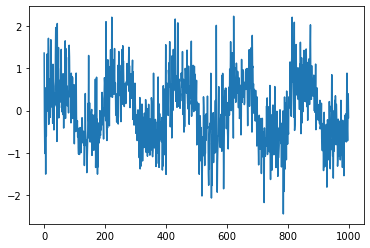

In [3]:
# Get familiar with inputs and target:
# plt.plot(input_1)
# plt.plot(input_2)
# plt.plot(input_3)
# plt.plot(input_4)
plt.plot(target)

In [4]:
# Check correlation of input series 1 and 2:
np.corrcoef(np.stack([inputs[:,0],inputs[:,1]]))

array([[1.        , 0.54729807],
       [0.54729807, 1.        ]])

In [5]:
### Define custom loss function:

## Our trading model would imply going "long" if the model predicts an up movement and going "short" else.

# If prediction and target have same sign, we are actually not losing money, which should be reflected as 
# zero loss in the loss function. Whereas using the classical mse loss would assign a positive loss value if
# prediction and target point in the same direction - but deviate.
# In our trading model we only lose money if the prediction was indicating an up movement and the market declines.
# In this case we have a negative target value and we find loss = -target (to have a positive loss value).
# In addition to that we have a second scenario where we lose money: If the model indicated a down movement and
# the market gains, we have a positive target value that equals the loss. Hence loss = target (positive loss value).

# Build vanilla mse loss:
def vanilla_mse(y_true, y_pred):
    
    eval = K.mean(K.square(y_true - y_pred))
    
    return eval


# Customize mse loss:
# In case, target and prediction have the same sign, want to have zero loss, and the regular mse, else.
def custom_mse(y_true, y_pred):
    
    squared_diff = K.cast(K.square(y_true - y_pred), dtype='float64')
    
    factor = K.cast(K.abs(K.sign(y_true) - K.sign(y_pred))/2, dtype='float64')
    
    return K.mean(squared_diff * factor)


# According to our trading model (described above), we can define the gain function for our strategy:
def gain(y_true, y_pred):
    
    eval = K.sign(y_pred) * y_true
    
    return eval

# And the outperformance compared to the naive buy-and-hold strategy is given by:
def outperformance(y_true, y_pred):
    
    eval = (K.sign(y_pred) - 1) * y_true
    
    return eval

In [6]:
# Define function to split time series 'sequence' into 'n_steps'
def split_sequence(sequence, n_steps):
    X = list()
    for i in range(len(sequence)):
        # Find the end of this pattern
        end_ix = i + n_steps
        # Check if we are beyond the sequence
        if end_ix > len(sequence):
            break
        # Gather input and output parts of the pattern
        seq_x = sequence[i:end_ix]
        X.append(seq_x)
    return np.array(X)

In [7]:
# Split input values into sequences of specified input length:
input_length = 20
inputs_split = split_sequence(inputs, input_length)

# Adjust targets: Cut first (input_length - 1) entries
target_cut = target[input_length-1:]

# Check dimensions:
print("inputs shape AFTER splitting (samples, timesteps, input features): ", inputs_split.shape)
print("target shape AFTER removing (input_length - 1) entries: ", target_cut.shape)

inputs shape AFTER splitting (samples, timesteps, input features):  (981, 20, 4)
target shape AFTER removing (input_length - 1) entries:  (981,)


In [8]:
## Split inputs and target into train and validation data:

# Specify rel. amount of train data:
train_val_split = 0.8

# Get corresponding number of train samples:
n_train = int(len(inputs) * train_val_split)

# Split inputs and target:
train_input = inputs_split[:n_train]
val_input = inputs_split[n_train:]
train_target = target_cut[:n_train]
val_target = target_cut[n_train:]

# Check dimensions:
print("INPUTS:")
print("=======")
print("train_input shape (samples, timesteps, input features): ", train_input.shape)
print("val_input shape (samples, timesteps, input features): ", val_input.shape)

print("\nTARGETS:")
print("=======")
print("train_target shape (samples, timesteps, input features): ", train_target.shape)
print("val_target shape (samples, timesteps, input features): ", val_target.shape)

INPUTS:
train_input shape (samples, timesteps, input features):  (800, 20, 4)
val_input shape (samples, timesteps, input features):  (181, 20, 4)

TARGETS:
train_target shape (samples, timesteps, input features):  (800,)
val_target shape (samples, timesteps, input features):  (181,)


### Train LSTM/fc with vanilla mse loss

In [9]:
# Set model parameters:
weight_init = tfi.glorot_uniform()
bias_init = tfi.Zeros()
LSTM_units = 10
batch_size = 10
n_epochs = 100
learning_rate=0.001
input_shape = (input_length, train_input.shape[-1]) # (time steps, features)

In [10]:
### Set up LSTM/fc model for single run experiment:

# Input layer
encoder_inputs = Input(shape=input_shape)

# Encoder LSTM: Only return last hidden states.
encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(
 LSTM_units, return_sequences=False, return_state=True)(encoder_inputs)

# As decoder, use single fc unit:
decoder_dense = Dense(1, name='decoder_dense')

# Connect fc unit to encoder:
output = decoder_dense(encoder_last_h2)

# Define and compile model 
model_mse = Model(encoder_inputs, output, name='model_encoder_decoder')
model_mse.compile(loss='mse', optimizer=Adam(lr=learning_rate), metrics=[custom_mse, gain, outperformance])
model_mse.summary()

Model: "model_encoder_decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20, 4)]           0         
_________________________________________________________________
lstm (LSTM)                  [(None, 10), (None, 10),  600       
_________________________________________________________________
decoder_dense (Dense)        (None, 1)                 11        
Total params: 611
Trainable params: 611
Non-trainable params: 0
_________________________________________________________________


2023-07-05 16:33:56.036299: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
# Train model:
history = model_mse.fit(train_input, train_target, epochs=n_epochs, batch_size=batch_size,
                    shuffle=True, verbose=1, validation_data=(val_input, val_target))

2023-07-05 16:34:04.663084: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/100
80/80 [==============================] - 1s 8ms/step - loss: 0.6119 - custom_mse: 0.4479 - gain: -0.1231 - outperformance: -0.1161 - val_loss: 0.3110 - val_custom_mse: 0.0538 - val_gain: 0.5466 - val_outperformance: 0.5639
Epoch 2/100
80/80 [==============================] - 0s 3ms/step - loss: 0.2852 - custom_mse: 0.0728 - gain: 0.5028 - outperformance: 0.4662 - val_loss: 0.2294 - val_custom_mse: 0.0769 - val_gain: 0.5458 - val_outperformance: 0.5631
Epoch 3/100
80/80 [==============================] - 0s 3ms/step - loss: 0.3066 - custom_mse: 0.1039 - gain: 0.5311 - outperformance: 0.5368 - val_loss: 0.2071 - val_custom_mse: 0.0691 - val_gain: 0.5450 - val_outperformance: 0.5623
Epoch 4/100
80/80 [==============================] - 0s 3ms/step - loss: 0.2303 - custom_mse: 0.0565 - gain: 0.5642 - outperformance: 0.5492 - val_loss: 0.1881 - val_custom_mse: 0.0523 - val_gain: 0.5565 - val_outperformance: 0.5739
Epoch 5/100
80/80 [==============================] - 0s 3ms/step -

80/80 [==============================] - 0s 3ms/step - loss: 0.1114 - custom_mse: 0.0192 - gain: 0.5674 - outperformance: 0.6075 - val_loss: 0.1055 - val_custom_mse: 0.0267 - val_gain: 0.5900 - val_outperformance: 0.6073
Epoch 37/100
80/80 [==============================] - 0s 3ms/step - loss: 0.1121 - custom_mse: 0.0212 - gain: 0.6025 - outperformance: 0.6245 - val_loss: 0.1059 - val_custom_mse: 0.0274 - val_gain: 0.5900 - val_outperformance: 0.6073
Epoch 38/100
80/80 [==============================] - 0s 3ms/step - loss: 0.1173 - custom_mse: 0.0217 - gain: 0.5789 - outperformance: 0.5886 - val_loss: 0.1084 - val_custom_mse: 0.0273 - val_gain: 0.5900 - val_outperformance: 0.6073
Epoch 39/100
80/80 [==============================] - 0s 3ms/step - loss: 0.1136 - custom_mse: 0.0143 - gain: 0.5933 - outperformance: 0.6285 - val_loss: 0.1057 - val_custom_mse: 0.0274 - val_gain: 0.5900 - val_outperformance: 0.6073
Epoch 40/100
80/80 [==============================] - 0s 3ms/step - loss: 0.1

80/80 [==============================] - 0s 3ms/step - loss: 0.1136 - custom_mse: 0.0203 - gain: 0.5558 - outperformance: 0.5271 - val_loss: 0.1029 - val_custom_mse: 0.0263 - val_gain: 0.5900 - val_outperformance: 0.6073
Epoch 72/100
80/80 [==============================] - 0s 3ms/step - loss: 0.1113 - custom_mse: 0.0175 - gain: 0.6028 - outperformance: 0.5563 - val_loss: 0.1043 - val_custom_mse: 0.0254 - val_gain: 0.5900 - val_outperformance: 0.6073
Epoch 73/100
80/80 [==============================] - 0s 3ms/step - loss: 0.1099 - custom_mse: 0.0236 - gain: 0.5841 - outperformance: 0.5495 - val_loss: 0.1046 - val_custom_mse: 0.0260 - val_gain: 0.5900 - val_outperformance: 0.6073
Epoch 74/100
80/80 [==============================] - 0s 3ms/step - loss: 0.1112 - custom_mse: 0.0157 - gain: 0.5846 - outperformance: 0.5810 - val_loss: 0.1047 - val_custom_mse: 0.0281 - val_gain: 0.5851 - val_outperformance: 0.6025
Epoch 75/100
80/80 [==============================] - 0s 3ms/step - loss: 0.1

In [38]:
# Set path:
path = Path('../results/LSTM_synthetic_data_mse')

In [21]:
# ## Store results:

# # Save trained model:
# model.save(path)

INFO:tensorflow:Assets written to: ../results/LSTM_synthetic_data_mse/assets


INFO:tensorflow:Assets written to: ../results/LSTM_synthetic_data_mse/assets


In [12]:
# ## Store loss (mse) and metrics (custom mse, gain, outperformance) histories:

# Extract histories:
train_mse = history.history['loss']
val_mse = history.history['val_loss']
train_custom_mse = history.history['custom_mse']
val_custom_mse = history.history['val_custom_mse']
train_gain = history.history['gain']
val_gain = history.history['val_gain']
train_outperformance = history.history['outperformance']
val_outperformance = history.history['val_outperformance']

# # Store histories:
# np.save(path / 'train_mse.npy', train_mse)
# np.save(path / 'val_mse.npy', val_mse)
# np.save(path / 'train_custom_mse.npy', train_custom_mse)
# np.save(path / 'val_custom_mse.npy', val_custom_mse)
# np.save(path / 'train_gain.npy', train_gain)
# np.save(path / 'val_gain.npy', val_gain)
# np.save(path / 'train_outperformance.npy', train_outperformance)
# np.save(path / 'val_outperformance.npy', val_outperformance)

#####################

# # Reload histories:
# train_mse = np.load(path / 'train_mse.npy')
# val_mse = np.load(path / 'val_mse.npy')
# train_custom_mse = np.load(path / 'train_custom_mse.npy')
# val_custom_mse = np.load(path / 'val_custom_mse.npy')
# train_gain = np.load(path / 'train_gain.npy')
# val_gain = np.load(path / 'val_gain.npy')
# train_outperformance = np.load(path / 'train_outperformance.npy')
# val_outperformance = np.load(path / 'val_outperformance.npy')

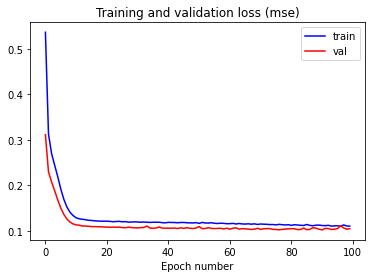

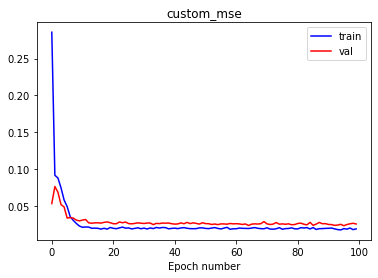

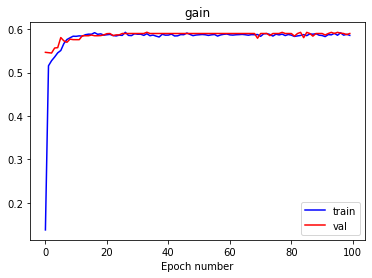

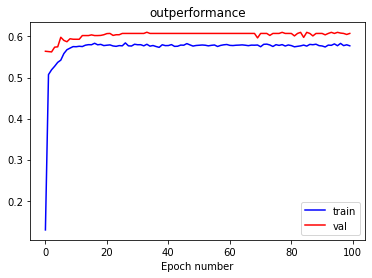

In [13]:
# Plot vanilla mse (loss):
plt.plot(train_mse, color = 'blue', label = 'train')
plt.plot(val_mse, color = 'red', label = 'val')
plt.xlabel('Epoch number')
#plt.ylim(0.6, 0.8)
plt.title('Training and validation loss (mse)')
plt.legend()
plt.show() 

# Plot custom mse:
plt.plot(train_custom_mse, color = 'blue', label = 'train')
plt.plot(val_custom_mse, color = 'red', label = 'val')
plt.xlabel('Epoch number')
#plt.ylim(0.6, 0.8)
plt.title('custom_mse')
plt.legend()
plt.show() 

# Plot gain:
plt.plot(train_gain, color = 'blue', label = 'train')
plt.plot(val_gain, color = 'red', label = 'val')
plt.xlabel('Epoch number')
#plt.ylim(0.6, 0.8)
plt.title('gain')
plt.legend()
plt.show() 

# Plot outperformance:
plt.plot(train_outperformance, color = 'blue', label = 'train')
plt.plot(val_outperformance, color = 'red', label = 'val')
plt.xlabel('Epoch number')
#plt.ylim(0.6, 0.8)
plt.title('outperformance')
plt.legend()
plt.show() 

In [14]:
# Find epoch with minimum validation loss (mse):
epoch_min = np.argmin(val_mse)
print('epoch with min. validation loss (mse):',epoch_min)
print('corresponding validation loss (mse):',np.round(val_mse[epoch_min],3))
print('corresponding custom mse:',np.round(val_custom_mse[epoch_min],3))
print('corresponding gain:',np.round(val_gain[epoch_min],3))
print('corresponding outperformance:',np.round(val_outperformance[epoch_min],3))

epoch with min. validation loss (mse): 90
corresponding validation loss (mse): 0.102
corresponding custom mse: 0.026
corresponding gain: 0.59
corresponding outperformance: 0.607


### Train LSTM/fc with custom mse loss

In [38]:
# Set model parameters:
weight_init = tfi.glorot_uniform()
bias_init = tfi.Zeros()
LSTM_units = 10
batch_size = 10
n_epochs = 100
learning_rate=0.001
input_shape = (input_length, train_input.shape[-1]) # (time steps, features)

In [44]:
### Set up LSTM/fc model for single run experiment:

# Input layer
encoder_inputs = Input(shape=input_shape)

# Encoder LSTM: Only return last hidden states.
encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(
 LSTM_units, return_sequences=False, return_state=True)(encoder_inputs)

# As decoder, use single fc unit:
decoder_dense = Dense(1, name='decoder_dense')

# Connect fc unit to encoder:
output = decoder_dense(encoder_last_h2)

# Define and compile model 
model_custom_mse = Model(encoder_inputs, output, name='model_encoder_decoder')
model_custom_mse.compile(loss=custom_mse, optimizer=Adam(lr=learning_rate), metrics=['mse', gain, outperformance])
model_custom_mse.summary()

Model: "model_encoder_decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 20, 4)]           0         
_________________________________________________________________
lstm_7 (LSTM)                [(None, 10), (None, 10),  600       
_________________________________________________________________
decoder_dense (Dense)        (None, 1)                 11        
Total params: 611
Trainable params: 611
Non-trainable params: 0
_________________________________________________________________


In [45]:
# Train model:
history = model_custom_mse.fit(train_input, train_target, epochs=n_epochs, batch_size=batch_size,
                    shuffle=True, verbose=1, validation_data=(val_input, val_target))

Epoch 1/100
80/80 [==============================] - 1s 6ms/step - loss: 0.4251 - mse: 0.6479 - gain: -0.0483 - outperformance: -0.0829 - val_loss: 0.0253 - val_mse: 0.4903 - val_gain: 0.5406 - val_outperformance: 0.5580
Epoch 2/100
80/80 [==============================] - 0s 3ms/step - loss: 0.0463 - mse: 0.5332 - gain: 0.5201 - outperformance: 0.5226 - val_loss: 0.0302 - val_mse: 0.5186 - val_gain: 0.5240 - val_outperformance: 0.5413
Epoch 3/100
80/80 [==============================] - 0s 3ms/step - loss: 0.0451 - mse: 0.5092 - gain: 0.4827 - outperformance: 0.4757 - val_loss: 0.0169 - val_mse: 0.5135 - val_gain: 0.5567 - val_outperformance: 0.5741
Epoch 4/100
80/80 [==============================] - 0s 3ms/step - loss: 0.0364 - mse: 0.5422 - gain: 0.5304 - outperformance: 0.5558 - val_loss: 0.0146 - val_mse: 0.5169 - val_gain: 0.5648 - val_outperformance: 0.5822
Epoch 5/100
80/80 [==============================] - 0s 3ms/step - loss: 0.0312 - mse: 0.5288 - gain: 0.5103 - outperforma

80/80 [==============================] - 0s 3ms/step - loss: 0.0110 - mse: 0.5705 - gain: 0.5868 - outperformance: 0.5679 - val_loss: 0.0171 - val_mse: 0.5498 - val_gain: 0.5559 - val_outperformance: 0.5732
Epoch 39/100
80/80 [==============================] - 0s 3ms/step - loss: 0.0200 - mse: 0.5389 - gain: 0.5384 - outperformance: 0.5748 - val_loss: 0.0123 - val_mse: 0.5470 - val_gain: 0.5663 - val_outperformance: 0.5837
Epoch 40/100
80/80 [==============================] - 0s 3ms/step - loss: 0.0140 - mse: 0.5330 - gain: 0.5526 - outperformance: 0.6082 - val_loss: 0.0086 - val_mse: 0.5475 - val_gain: 0.5805 - val_outperformance: 0.5978
Epoch 41/100
80/80 [==============================] - 0s 3ms/step - loss: 0.0107 - mse: 0.5668 - gain: 0.5699 - outperformance: 0.5632 - val_loss: 0.0105 - val_mse: 0.5489 - val_gain: 0.5732 - val_outperformance: 0.5905
Epoch 42/100
80/80 [==============================] - 0s 3ms/step - loss: 0.0160 - mse: 0.5582 - gain: 0.5732 - outperformance: 0.581

80/80 [==============================] - 0s 3ms/step - loss: 0.0179 - mse: 0.6195 - gain: 0.5998 - outperformance: 0.6213 - val_loss: 0.0067 - val_mse: 0.5494 - val_gain: 0.5889 - val_outperformance: 0.6062
Epoch 76/100
80/80 [==============================] - 0s 3ms/step - loss: 0.0092 - mse: 0.6079 - gain: 0.6147 - outperformance: 0.5649 - val_loss: 0.0092 - val_mse: 0.5521 - val_gain: 0.5790 - val_outperformance: 0.5963
Epoch 77/100
80/80 [==============================] - 0s 3ms/step - loss: 0.0092 - mse: 0.5143 - gain: 0.5444 - outperformance: 0.5148 - val_loss: 0.0117 - val_mse: 0.5571 - val_gain: 0.5757 - val_outperformance: 0.5930
Epoch 78/100
80/80 [==============================] - 0s 3ms/step - loss: 0.0096 - mse: 0.5603 - gain: 0.5931 - outperformance: 0.5843 - val_loss: 0.0086 - val_mse: 0.5573 - val_gain: 0.5789 - val_outperformance: 0.5962
Epoch 79/100
80/80 [==============================] - 0s 3ms/step - loss: 0.0111 - mse: 0.6164 - gain: 0.6060 - outperformance: 0.552

In [46]:
# Set path:
path = Path('../results/LSTM_synthetic_data_custom_mse')

In [47]:
# ## Store results:

# # Save trained model:
# model.save(path)

In [48]:
# ## Store loss (mse) and metrics (custom mse, gain, outperformance) histories:

# Extract histories:
train_mse = history.history['mse']
val_mse = history.history['val_mse']
train_custom_mse = history.history['loss']
val_custom_mse = history.history['val_loss']
train_gain = history.history['gain']
val_gain = history.history['val_gain']
train_outperformance = history.history['outperformance']
val_outperformance = history.history['val_outperformance']

# # Store histories:
# np.save(path / 'train_mse.npy', train_mse)
# np.save(path / 'val_mse.npy', val_mse)
# np.save(path / 'train_custom_mse.npy', train_custom_mse)
# np.save(path / 'val_custom_mse.npy', val_custom_mse)
# np.save(path / 'train_gain.npy', train_gain)
# np.save(path / 'val_gain.npy', val_gain)
# np.save(path / 'train_outperformance.npy', train_outperformance)
# np.save(path / 'val_outperformance.npy', val_outperformance)

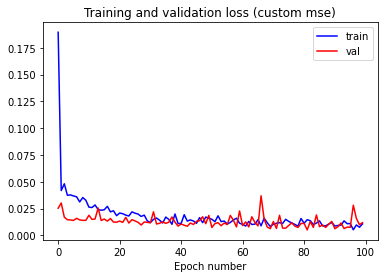

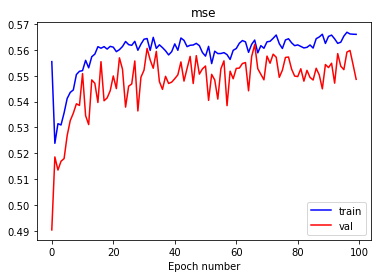

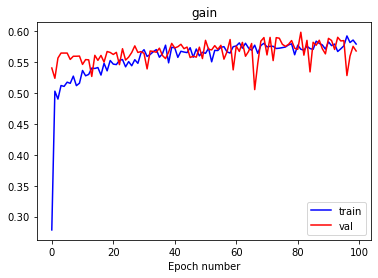

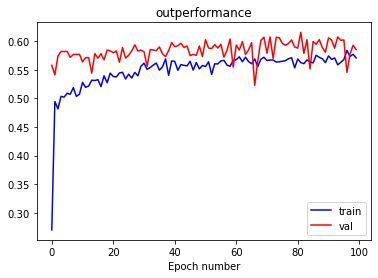

In [49]:
# Plot custom mse (loss):
plt.plot(train_custom_mse, color = 'blue', label = 'train')
plt.plot(val_custom_mse, color = 'red', label = 'val')
plt.xlabel('Epoch number')
#plt.ylim(0.6, 0.8)
plt.title('Training and validation loss (custom mse)')
plt.legend()
plt.show() 

# Plot mse:
plt.plot(train_mse, color = 'blue', label = 'train')
plt.plot(val_mse, color = 'red', label = 'val')
plt.xlabel('Epoch number')
#plt.ylim(0.6, 0.8)
plt.title('mse')
plt.legend()
plt.show() 

# Plot gain:
plt.plot(train_gain, color = 'blue', label = 'train')
plt.plot(val_gain, color = 'red', label = 'val')
plt.xlabel('Epoch number')
#plt.ylim(0.6, 0.8)
plt.title('gain')
plt.legend()
plt.show() 

# Plot outperformance:
plt.plot(train_outperformance, color = 'blue', label = 'train')
plt.plot(val_outperformance, color = 'red', label = 'val')
plt.xlabel('Epoch number')
#plt.ylim(0.6, 0.8)
plt.title('outperformance')
plt.legend()
plt.show() 

In [50]:
# Find epoch with minimum validation loss (custom mse):
epoch_min = np.argmin(val_custom_mse)
print('epoch with min. validation loss:',epoch_min)
print('corresponding validation loss (custom mse):',np.round(val_custom_mse[epoch_min],3))
print('corresponding mse:',np.round(val_mse[epoch_min],3))
print('corresponding gain:',np.round(val_gain[epoch_min],3))
print('corresponding outperformance:',np.round(val_outperformance[epoch_min],3))

epoch with min. validation loss: 81
corresponding validation loss (custom mse): 0.005
corresponding mse: 0.553
corresponding gain: 0.599
corresponding outperformance: 0.616


### Train LSTM/fc with custom mse loss

Set **batch size = 1**, to consider each input sample individually and fully take advantage of the custom mse loss.

In [42]:
# Set model parameters:
weight_init = tfi.glorot_uniform()
bias_init = tfi.Zeros()
LSTM_units = 10
batch_size = 1
n_epochs = 100
learning_rate=0.001
input_shape = (input_length, train_input.shape[-1]) # (time steps, features)

In [43]:
### Set up LSTM/fc model for single run experiment:

# Input layer
encoder_inputs = Input(shape=input_shape)

# Encoder LSTM: Only return last hidden states.
encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(
 LSTM_units, return_sequences=False, return_state=True)(encoder_inputs)

# As decoder, use single fc unit:
decoder_dense = Dense(1, name='decoder_dense')

# Connect fc unit to encoder:
output = decoder_dense(encoder_last_h2)

# Define and compile model 
model = Model(encoder_inputs, output, name='model_encoder_decoder')
model.compile(loss=custom_mse, optimizer=Adam(lr=learning_rate), metrics=['mse', gain, outperformance])
model.summary()

Model: "model_encoder_decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 20, 4)]           0         
_________________________________________________________________
lstm_2 (LSTM)                [(None, 10), (None, 10),  600       
_________________________________________________________________
decoder_dense (Dense)        (None, 1)                 11        
Total params: 611
Trainable params: 611
Non-trainable params: 0
_________________________________________________________________


In [44]:
# Train model:
history = model.fit(train_input, train_target, epochs=n_epochs, batch_size=batch_size,
                    shuffle=True, verbose=1, validation_data=(val_input, val_target))

Epoch 1/100
800/800 [==============================] - 3s 3ms/step - loss: 0.1566 - mse: 0.5138 - gain: 0.3137 - outperformance: 0.2846 - val_loss: 0.0326 - val_mse: 0.4589 - val_gain: 0.5157 - val_outperformance: 0.5330
Epoch 2/100
800/800 [==============================] - 2s 2ms/step - loss: 0.0359 - mse: 0.4779 - gain: 0.4914 - outperformance: 0.5089 - val_loss: 0.0279 - val_mse: 0.4879 - val_gain: 0.5249 - val_outperformance: 0.5423
Epoch 3/100
800/800 [==============================] - 2s 2ms/step - loss: 0.0406 - mse: 0.4612 - gain: 0.4896 - outperformance: 0.4706 - val_loss: 0.0228 - val_mse: 0.5116 - val_gain: 0.5323 - val_outperformance: 0.5496
Epoch 4/100
800/800 [==============================] - 2s 2ms/step - loss: 0.0187 - mse: 0.5505 - gain: 0.5807 - outperformance: 0.6046 - val_loss: 0.0145 - val_mse: 0.4653 - val_gain: 0.5665 - val_outperformance: 0.5839
Epoch 5/100
800/800 [==============================] - 2s 2ms/step - loss: 0.0214 - mse: 0.5030 - gain: 0.5484 - out

Epoch 38/100
800/800 [==============================] - 2s 2ms/step - loss: 0.0084 - mse: 0.5126 - gain: 0.5662 - outperformance: 0.6088 - val_loss: 0.0076 - val_mse: 0.5410 - val_gain: 0.5875 - val_outperformance: 0.6048
Epoch 39/100
800/800 [==============================] - 2s 3ms/step - loss: 0.0086 - mse: 0.5695 - gain: 0.5863 - outperformance: 0.5613 - val_loss: 0.0084 - val_mse: 0.5402 - val_gain: 0.5807 - val_outperformance: 0.5980
Epoch 40/100
800/800 [==============================] - 2s 3ms/step - loss: 0.0092 - mse: 0.6054 - gain: 0.6174 - outperformance: 0.6162 - val_loss: 0.0172 - val_mse: 0.5456 - val_gain: 0.5401 - val_outperformance: 0.5574
Epoch 41/100
800/800 [==============================] - 2s 2ms/step - loss: 0.0108 - mse: 0.5555 - gain: 0.5732 - outperformance: 0.5827 - val_loss: 0.0150 - val_mse: 0.5418 - val_gain: 0.5470 - val_outperformance: 0.5643
Epoch 42/100
800/800 [==============================] - 2s 3ms/step - loss: 0.0119 - mse: 0.5298 - gain: 0.5564 

Epoch 75/100
800/800 [==============================] - 2s 2ms/step - loss: 0.0081 - mse: 0.5650 - gain: 0.5783 - outperformance: 0.5395 - val_loss: 0.0108 - val_mse: 0.5521 - val_gain: 0.5730 - val_outperformance: 0.5904
Epoch 76/100
800/800 [==============================] - 2s 2ms/step - loss: 0.0042 - mse: 0.5778 - gain: 0.6080 - outperformance: 0.5898 - val_loss: 0.0425 - val_mse: 0.5600 - val_gain: 0.4914 - val_outperformance: 0.5088
Epoch 77/100
800/800 [==============================] - 2s 2ms/step - loss: 0.0130 - mse: 0.5840 - gain: 0.5807 - outperformance: 0.6128 - val_loss: 0.0084 - val_mse: 0.5554 - val_gain: 0.5814 - val_outperformance: 0.5988
Epoch 78/100
800/800 [==============================] - 2s 2ms/step - loss: 0.0043 - mse: 0.6248 - gain: 0.6351 - outperformance: 0.5780 - val_loss: 0.0072 - val_mse: 0.5586 - val_gain: 0.5884 - val_outperformance: 0.6058
Epoch 79/100
800/800 [==============================] - 2s 2ms/step - loss: 0.0070 - mse: 0.5556 - gain: 0.5730 

In [46]:
# Set path:
path = Path('../results/LSTM_synthetic_data_custom_mse_batchsize_1')

In [47]:
# ## Store results:

# # Save trained model:
# model.save(path)

INFO:tensorflow:Assets written to: ../results/LSTM_synthetic_data_custom_mse_batchsize_1/assets


INFO:tensorflow:Assets written to: ../results/LSTM_synthetic_data_custom_mse_batchsize_1/assets


In [48]:
# ## Store loss (mse) and metrics (custom mse, gain, outperformance) histories:

# # Extract histories:
# train_mse = history.history['mse']
# val_mse = history.history['val_mse']
# train_custom_mse = history.history['loss']
# val_custom_mse = history.history['val_loss']
# train_gain = history.history['gain']
# val_gain = history.history['val_gain']
# train_outperformance = history.history['outperformance']
# val_outperformance = history.history['val_outperformance']

# # Store histories:
# np.save(path / 'train_mse.npy', train_mse)
# np.save(path / 'val_mse.npy', val_mse)
# np.save(path / 'train_custom_mse.npy', train_custom_mse)
# np.save(path / 'val_custom_mse.npy', val_custom_mse)
# np.save(path / 'train_gain.npy', train_gain)
# np.save(path / 'val_gain.npy', val_gain)
# np.save(path / 'train_outperformance.npy', train_outperformance)
# np.save(path / 'val_outperformance.npy', val_outperformance)

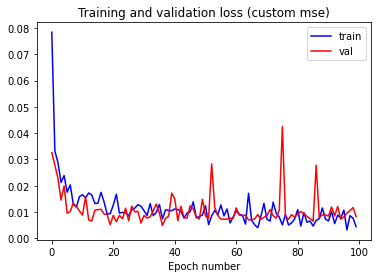

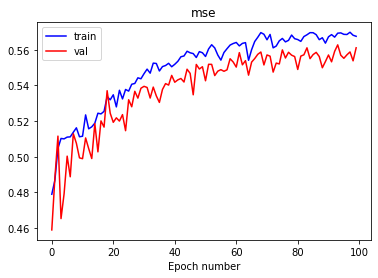

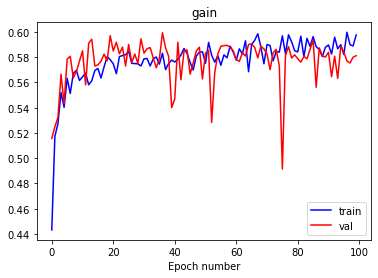

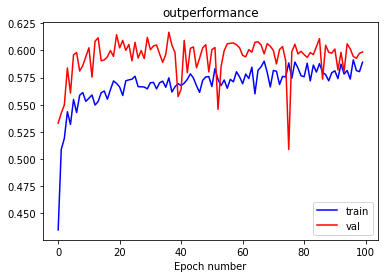

In [49]:
# Plot custom mse (loss):
plt.plot(train_custom_mse, color = 'blue', label = 'train')
plt.plot(val_custom_mse, color = 'red', label = 'val')
plt.xlabel('Epoch number')
#plt.ylim(0.6, 0.8)
plt.title('Training and validation loss (custom mse)')
plt.legend()
plt.show() 

# Plot mse:
plt.plot(train_mse, color = 'blue', label = 'train')
plt.plot(val_mse, color = 'red', label = 'val')
plt.xlabel('Epoch number')
#plt.ylim(0.6, 0.8)
plt.title('mse')
plt.legend()
plt.show() 

# Plot gain:
plt.plot(train_gain, color = 'blue', label = 'train')
plt.plot(val_gain, color = 'red', label = 'val')
plt.xlabel('Epoch number')
#plt.ylim(0.6, 0.8)
plt.title('gain')
plt.legend()
plt.show() 

# Plot outperformance:
plt.plot(train_outperformance, color = 'blue', label = 'train')
plt.plot(val_outperformance, color = 'red', label = 'val')
plt.xlabel('Epoch number')
#plt.ylim(0.6, 0.8)
plt.title('outperformance')
plt.legend()
plt.show() 

In [50]:
# Find epoch with minimum validation loss (custom mse):
epoch_min = np.argmin(val_custom_mse)
print('epoch with min. validation loss:',epoch_min)
print('corresponding validation loss (custom mse):',np.round(val_custom_mse[epoch_min],3))
print('corresponding mse:',np.round(val_mse[epoch_min],3))
print('corresponding gain:',np.round(val_gain[epoch_min],3))
print('corresponding outperformance:',np.round(val_outperformance[epoch_min],3))

epoch with min. validation loss: 36
corresponding validation loss (custom mse): 0.005
corresponding mse: 0.538
corresponding gain: 0.599
corresponding outperformance: 0.617


### Discussion: LSTM/fc with custom mse

Batch size = 1 leads to similar minimum custom mse, gain and outperformance, compared to batch size = 10.
However, the corresponding mse is found to be lower.

### Evaluation

In [76]:
# Get predictions from LSTM/fc models trained with mse and custom mse, both with batch size = 10:
val_pred_mse = model_mse.predict(val_input)[:,0]
val_pred_custom_mse = model_custom_mse.predict(val_input)[:,0]
train_pred_mse = model_mse.predict(train_input)[:,0]
train_pred_custom_mse = model_custom_mse.predict(train_input)[:,0]

In [77]:
# Get binary accuracy for LSTM/fc models trained with mse and custom mse, both with batch size = 10:
print('train accuracy for LSTM/fc model with mse:',np.round(
    sum(np.sign(train_target)==np.sign(train_pred_mse))/len(train_target),3))
print('train accuracy for LSTM/fc model with custom mse:',np.round(
    sum(np.sign(train_target)==np.sign(train_pred_custom_mse))/len(train_target),3))
print('val accuracy for LSTM/fc model with mse:',np.round(
    sum(np.sign(val_target)==np.sign(val_pred_mse))/len(val_target),3))
print('val accuracy for LSTM/fc model with custom mse:',np.round(
    sum(np.sign(val_target)==np.sign(val_pred_custom_mse))/len(val_target),3))

train accuracy for LSTM/fc model with mse: 0.9
train accuracy for LSTM/fc model with custom mse: 0.908
val accuracy for LSTM/fc model with mse: 0.895
val accuracy for LSTM/fc model with custom mse: 0.884


In [78]:
# Get time steps, where target and prediction match / don't match:
val_match_mse = (np.sign(val_target)==np.sign(val_pred_mse))
val_match_custom_mse = (np.sign(val_target)==np.sign(val_pred_custom_mse))
val_nomatch_mse = (np.sign(val_target)!=np.sign(val_pred_mse))
val_nomatch_custom_mse = (np.sign(val_target)!=np.sign(val_pred_custom_mse))
train_match_mse = (np.sign(train_target)==np.sign(train_pred_mse))
train_match_custom_mse = (np.sign(train_target)==np.sign(train_pred_custom_mse))
train_nomatch_mse = (np.sign(train_target)!=np.sign(train_pred_mse))
train_nomatch_custom_mse = (np.sign(train_target)!=np.sign(train_pred_custom_mse))

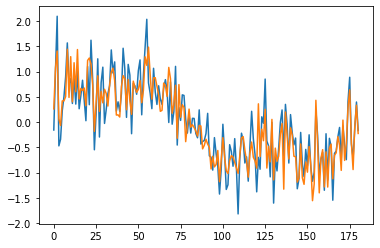

In [82]:
plt.plot(val_target)
plt.plot(val_pred_mse)

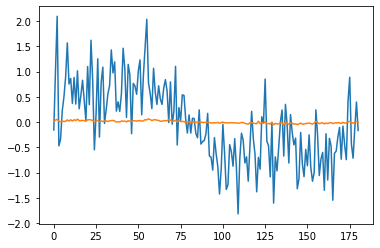

In [85]:
plt.plot(val_target)
plt.plot(val_pred_custom_mse)

In [55]:
## Alternatively set up LSTM/fc model as sequential model:

# Start model definition:
model = Sequential()

# Add input layer:
model.add(Input(shape=input_shape))

# Encoder LSTM: Only return last hidden states.
model.add(LSTM(units=LSTM_units, return_sequences=False, return_state=False))
    
## As decoder, use single fc unit:
model.add(Dense(units=1, name="decoder_dense"))

# Define and compile model 
model.compile(loss=custom_mse, optimizer=Adam(lr=learning_rate), metrics=['mse', gain, outperformance])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 10)                600       
_________________________________________________________________
decoder_dense (Dense)        (None, 1)                 11        
Total params: 611
Trainable params: 611
Non-trainable params: 0
_________________________________________________________________
